<a href="https://colab.research.google.com/github/ritiksharmasde/Deep_Learning/blob/main/ORBIT_PREDICTION_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load Data
file_path = "2.csv"
df = pd.read_csv(file_path)

# Select Features & Target
features = ['Calendar Date (TDB)', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR',
            'Semi-major axis', 'Eccentricity', 'Inclination', 'Longitude of Ascending Node',
            'Argument of Periapsis', 'True Anomaly', 'Distance_from_Sun (r)',
            'Specific_Angular_Momentum (h_x)', 'Specific_Angular_Momentum (h_y)',
            'Specific_Angular_Momentum (h_z)', 'Specific_Orbital_Energy (E)']

target = ['X', 'Y', 'Z', 'VX', 'VY', 'VZ']

# Convert Date to Numerical Format
df['Calendar Date (TDB)'] = pd.to_datetime(df['Calendar Date (TDB)'], errors='coerce')
df['Calendar Date (TDB)'] = df['Calendar Date (TDB)'].astype('int64') // 10**9  # Convert to seconds

# Normalize Features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Create Sequences for LSTM
sequence_length = 7  # 7 days of past data
X_data, y_data = [], []

for i in range(len(df) - sequence_length):
    X_data.append(df[features].iloc[i:i+sequence_length].values)
    y_data.append(df[target].iloc[i+sequence_length].values)

X_data, y_data = np.array(X_data), np.array(y_data)

# 10-Fold Cross-Validation
kf = KFold(n_splits=2, shuffle=False)
train_losses, val_losses, val_accuracies = [], [], []

# Define LSTM Model Function
def create_model():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(sequence_length, len(features))),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(6)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Train & Evaluate Model on Each Fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
    print(f"\nTraining on Fold {fold + 1}...\n")

    # Split Data
    X_train, X_val = X_data[train_idx], X_data[val_idx]
    y_train, y_val = y_data[train_idx], y_data[val_idx]

    # Create Model
    model = create_model()

    # Learning Rate Scheduler
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    # Train Model
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val),
                        callbacks=[reduce_lr], verbose=1)

    # Store Loss & Accuracy
    train_losses.append(history.history['loss'][-1])  # Last epoch train loss
    val_losses.append(history.history['val_loss'][-1])  # Last epoch val loss
    val_accuracies.append(history.history['val_mae'][-1])  # Last epoch validation MAE

# Compute Mean & Standard Deviation
train_loss_mean, train_loss_std = np.mean(train_losses), np.std(train_losses)
val_loss_mean, val_loss_std = np.mean(val_losses), np.std(val_losses)
val_acc_mean, val_acc_std = np.mean(val_accuracies), np.std(val_accuracies)

# Print Final Results
print("\n=== Cross-Validation Results ===")
print(f"Train Loss: {train_loss_mean:.4f} ± {train_loss_std:.4f}")
print(f"Validation Loss: {val_loss_mean:.4f} ± {val_loss_std:.4f}")
print(f"Validation Accuracy (MAE): {val_acc_mean:.4f} ± {val_acc_std:.4f}")

# -------------------below-----------------------------
# # 📌 Step 1: Install & Import Dependencies
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from google.colab import files
# from sklearn.preprocessing import StandardScaler
# import os
# import shutil

# # 📌 Step 2: Upload & Load Pre-Scaled CSV
# file_path = "2.CSV"
# df = pd.read_csv(file_path)

# # 📌 Step 3: Data Preprocessing
# features = ['X', 'Y', 'Z', 'VX', 'VY', 'VZ']
# target = ['X', 'Y', 'Z', 'VX', 'VY', 'VZ']

# # Scale the data
# scaler = StandardScaler()
# df_scaled = df.copy()
# df_scaled[features] = scaler.fit_transform(df[features])

# sequence_length = 7
# X_data, y_data = [], []

# for i in range(len(df_scaled) - sequence_length):
#     X_data.append(df_scaled[features].iloc[i:i+sequence_length].values)
#     y_data.append(df_scaled[target].iloc[i+sequence_length].values)

# X_data, y_data = np.array(X_data), np.array(y_data)

# # Train-Test Split (80-20)
# split_idx = int(len(X_data) * 0.8)
# X_train, X_test = X_data[:split_idx], X_data[split_idx:]
# y_train, y_test = y_data[:split_idx], y_data[split_idx:]

# # 📌 Step 4: Build & Train LSTM Model
# model = Sequential([
#     LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, len(features))),
#     LSTM(32, activation='relu'),
#     Dense(6)  # Predicting X, Y, Z, VX, VY, VZ
# ])

# model.compile(optimizer='adam', loss='mse')
# history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# # 📌 Step 5: Predict Future Position (Next 7 Days)
# future_X = X_test[-1].reshape(1, sequence_length, len(features))
# future_predictions = []

# for _ in range(30):
#     pred = model.predict(future_X)[0]
#     future_predictions.append(pred)

#     future_X = np.roll(future_X, -1, axis=1)
#     future_X[0, -1, :] = pred  # Correctly update last step

# # Convert predictions to DataFrame
# pred_df = pd.DataFrame(future_predictions, columns=['Pred_X', 'Pred_Y', 'Pred_Z','Pred_VX','Pred_VY','Pred_VZ'])
# pred_df.to_csv('Earth_Next_Week_Predictions.csv', index=False)

# # 📌 Step 6: Download CSV
# if 'google.colab' in str(get_ipython()):
#     files.download('Earth_Next_Week_Predictions.csv')
# else:
#     shutil.move("Earth_Next_Week_Predictions.csv", os.path.expanduser("~/Downloads/"))

# # 📌 Step 7: Plot Predictions
# plt.figure(figsize=(10, 5))
# plt.plot(pred_df['Pred_X'], label='Predicted X', marker='o')
# plt.plot(pred_df['Pred_Y'], label='Predicted Y', marker='s')
# plt.plot(pred_df['Pred_Z'], label='Predicted Z', marker='^')
# plt.legend()
# plt.title('Predicted Earth Position for Next Week')
# plt.xlabel('Days')
# plt.ylabel('Position Values')
# plt.grid()
# plt.show()

# # 📌 Step 8: Save the Model
# model.save('LSTM_Earth_Model.h5')

# # 📌 Step 9: Download Model (Colab only)
# # if 'google.colab' in str(get_ipython()):
# #     files.download('LSTM_Earth_Model.h5')


<ipython-input-13-4f04685d7f2f>:25: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Calendar Date (TDB)'] = pd.to_datetime(df['Calendar Date (TDB)'], errors='coerce')



Training on Fold 1...

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.5309 - mae: 0.5768 - val_loss: 0.4857 - val_mae: 0.4814 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0839 - mae: 0.1905 - val_loss: 0.3932 - val_mae: 0.4695 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0763 - mae: 0.1846 - val_loss: 0.3188 - val_mae: 0.4234 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0678 - mae: 0.1659 - val_loss: 0.2857 - val_mae: 0.3981 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0585 - mae: 0.1502 - val_loss: 0.2293 - val_mae: 0.3676 - learning_rate: 0.0010
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0533 - mae: 0.1450 - val_loss: 0.2132 - val_mae: 0.3618 - learning_rate: 0.0010
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0446 - mae: 0.1408 - val_loss: 0.1604 - val_mae: 0.3229 - learning_rate: 0.0010
Epoch 8/50
83/83 ━━━━━━━

In [ ]:
# y_pred = model.predict(X_test)

# # Convert back to original scale if you used StandardScaler
# y_pred_original = scaler.inverse_transform(y_pred)
# y_test_original = scaler.inverse_transform(y_test)

# # Compare predictions vs actual values
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(y_test_original[:, 0], label='Actual X', linestyle='dashed')
# plt.plot(y_pred_original[:, 0], label='Predicted X')
# plt.legend()
# plt.title("Model Predictions vs Actual Values")
# plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 


ValueError: operands could not be broadcast together with shapes (78,3) (6,) (78,3) 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files  # Needed for Colab downloads

# Step 1: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Step 2: Convert Predictions Back to Original Scale (if scaling was used)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 6))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 6))

# Step 3: Compute Evaluation Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# Step 4: Print Accuracy Results
print(f"📊 Model Evaluation Metrics:")
print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

# Step 5: Save Predictions to CSV
df_results = pd.DataFrame({
    'Actual_X': y_test_original[:, 0], 'Predicted_X': y_pred_original[:, 0],
    'Actual_Y': y_test_original[:, 1], 'Predicted_Y': y_pred_original[:, 1],
    'Actual_Z': y_test_original[:, 2], 'Predicted_Z': y_pred_original[:, 2],
    'Actual_VX': y_test_original[:, 3], 'Predicted_VX': y_pred_original[:, 3],
    'Actual_VY': y_test_original[:, 4], 'Predicted_VY': y_pred_original[:, 4],
    'Actual_VZ': y_test_original[:, 5], 'Predicted_VZ': y_pred_original[:, 5]
})

df_results.to_csv('Predictions.csv', index=False)

# Step 6: Download CSV
if 'google.colab' in str(get_ipython()):
    files.download('Predictions.csv')  # For Google Colab
else:
    import shutil
    import os
    shutil.move("Predictions.csv", os.path.expanduser("~/Downloads/"))  # For local execution


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
📊 Model Evaluation Metrics:
🔹 Mean Absolute Error (MAE): 0.1747
🔹 Mean Squared Error (MSE): 0.0581
🔹 Root Mean Squared Error (RMSE): 0.2410
🔹 R² Score: 0.7340


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


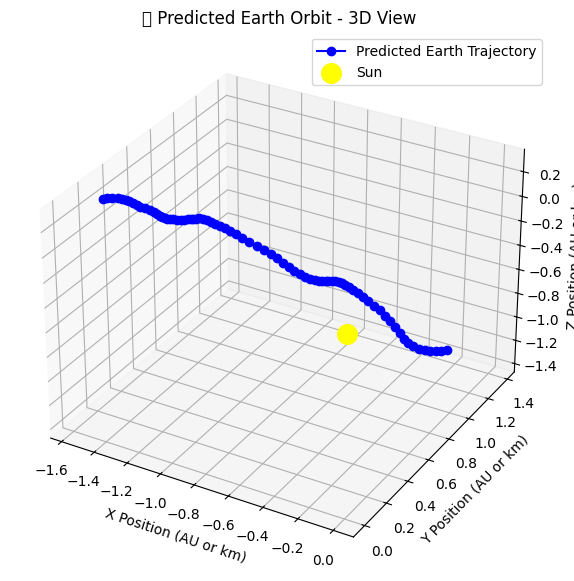

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 📌 Load the predicted positions (Make sure the CSV is generated from previous steps)
pred_df = pd.read_csv("Predictions.csv")

# 📌 Extract X, Y, Z coordinates
x_pred = pred_df["Predicted_X"]
y_pred = pred_df["Predicted_Y"]
z_pred = pred_df["Predicted_Z"]

# 📌 Set up a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 📌 Plot the Earth's predicted orbit
ax.plot(x_pred, y_pred, z_pred, marker='o', linestyle='-', color='b', label="Predicted Earth Trajectory")

# 📌 Mark the Sun at the center (0,0,0)
ax.scatter(0, 0, 0, color='yellow', marker='o', s=200, label="Sun")

# 📌 Labels & Title
ax.set_xlabel("X Position (AU or km)")
ax.set_ylabel("Y Position (AU or km)")
ax.set_zlabel("Z Position (AU or km)")
ax.set_title("🌍 Predicted Earth Orbit - 3D View")

# 📌 Legend & Grid
ax.legend()
ax.grid()

# 📌 Show the 3D plot
plt.show()
